# MNIST CLASSIFIER

`MNIST contains 70,000 images of handwritten digits: 60,000 for training and 10,000 for testing. The images are grayscale, 28x28 pixels, and centered to reduce preprocessing and get started quicker.` 

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gzip
import numpy as np
import tarfile
import os
import math
#import tensorflow as tf

In [2]:
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-03-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

In [3]:
def extract_data(filename, image_shape, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(np.prod(image_shape) * image_number)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(image_number, image_shape[0], image_shape[1])
    return data


def extract_labels(filename, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * image_number)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

In [4]:
image_shape = (28, 28)
train_set_size = 60000
test_set_size = 10000
data_part2_folder = os.path.join(data_base_path, data_folder, 'part2')

test_images_path = os.path.join(data_part2_folder, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_part2_folder, 't10k-labels-idx1-ubyte.gz')

test_images = extract_data(test_images_path, image_shape, test_set_size)
test_labels = extract_labels(test_labels_path, test_set_size)

test_input = torch.from_numpy(test_images.reshape(test_images.shape[0], 1, test_images.shape[1], test_images.shape[2]))
test_target = torch.from_numpy(test_labels)

In [5]:
class MNISTdataset(Dataset):

    def __init__(self, transform=None):
        
        image_shape = (28, 28)
        train_set_size = 60000
        #test_set_size = 10000
        data_part2_folder = os.path.join(data_base_path, data_folder, 'part2')
        
        train_images_path = os.path.join(data_part2_folder, 'train-images-idx3-ubyte.gz')
        train_labels_path = os.path.join(data_part2_folder, 'train-labels-idx1-ubyte.gz')
        #test_images_path = os.path.join(data_part2_folder, 't10k-images-idx3-ubyte.gz')
        #test_labels_path = os.path.join(data_part2_folder, 't10k-labels-idx1-ubyte.gz')

        train_images = extract_data(train_images_path, image_shape, train_set_size)
        train_labels = extract_labels(train_labels_path, train_set_size)
        #test_images = extract_data(test_images_path, image_shape, test_set_size)
        #test_labels = extract_labels(test_labels_path, test_set_size)
        
        self.train_input = train_images.reshape(train_images.shape[0], 1, train_images.shape[1], train_images.shape[2])
        #self.train_input = tf.image.grayscale_to_rgb(train_images.reshape(train_images.shape[0], 1, train_images.shape[1], train_images.shape[2]))
        #print(type(self.train_input))
        #self.train_target = train_labels
        
        #self.train_input = torch.from_numpy(train_images.reshape(train_images.shape[0], 1, train_images.shape[1], train_images.shape[2]))
        self.train_target = torch.from_numpy(train_labels)        
        #self.test_input = torch.from_numpy(test_images.reshape(test_images.shape[0], 1, test_images.shape[1], test_images.shape[2]))
        #self.test_target = torch.from_numpy(test_labels)
                
        self.nb_samples = train_images.shape[0]
        
        self.transform = transform
    
    def __getitem__(self, index):
        if self.transform:
            #print('TRANSFORM')
            transfo = self.transform(self.train_input[index])
            return transfo, self.train_target[index]
        else:
            #print('NO TRANSFORM')
            return self.train_input[index], self.train_target[index]

    def __len__(self):
        # so that we can use len(dataset)
        return self.nb_samples

In [6]:
dataset = MNISTdataset()

# test class we built
first_data = dataset[0]
features, labels = first_data
print('FEATURES:',features)
print('LABELS:', labels)

FEATURES: [[[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
     0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
     0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
     0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
     0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
     0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   3.  18.
    18.  18. 126. 136. 175.  26. 166. 255. 247. 127.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.   0.   0.   0.  30.  36.  94. 154. 170. 253.
   253. 253. 253. 253. 225. 172. 25

In [7]:
dataloader = DataLoader(dataset=dataset, batch_size = 5, shuffle=True)
dataiter = iter(dataloader)
data = dataiter.next()
features, labels = data
print('FEATURES:',features)
print('LABELS:', labels)

FEATURES: tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0.,

In [8]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.ToPILImage(),
    #torchvision.transforms.RandomRotation(20),
    #torchvision.transforms.RandomResizedCrop(28),
    torchvision.transforms.Resize((28,28)),
    #torchvision.transforms.RandomHorizontalFlip(),
    #torchvision.transforms.Grayscale(),
    torchvision.transforms.ToTensor()])
    #torchvision.transforms.Normalize((0.1307,), (0.3081,))])
dataset2 = MNISTdataset(transform=train_transforms)
first_data2 = dataset2[10]
features2, labels2 = first_data2
#print(type(features2), type(labels2))
#print(features2, labels2)

In [9]:
features2.size()

torch.Size([3, 28, 28])

In [10]:
features2[:,0,:].size()

torch.Size([3, 28])

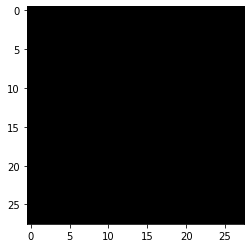

In [17]:
plt.imshow(features2[0,:,:], cmap='gray')

In [12]:
dataloader = DataLoader(dataset=dataset2, batch_size = 5, shuffle=True)
dataiter = iter(dataloader)
data = dataiter.next()
features, labels = data
print('FEATURES:',features)
print('LABELS:', labels)

FEATURES: tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.]

In [13]:
# The ConvNet module is a simple network that applies a convolution filter before the multi-layer perceptron
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        # Pre-processing with a convolutional filter
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5) 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        
        # MLP 1 layer, 100 units : The output of the convolutional layer is reduce into a single vector of size 256 -> 100 -> 10 through the MLP
        self.fc1 = nn.Linear(256, 100)
        self.fc2 = nn.Linear(100, 10) # output 10 classes
        
        #Dropout method drop connections between nodes in the MLP during training to reduce training time and avoid over-fitting
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):
        
        # Pre-processing with a convolutional filter
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=3, stride=3))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
       
        # MLP 1 layer, 100 units
        x = self.dropout(F.relu(self.fc1(x.view(-1, 256))))
        x = self.fc2(x)
        
        return x

In [14]:
# Training 
def train_model(model, train_input, train_target, mini_batch_size): 
        criterion = torch.nn.CrossEntropyLoss()  # Loss criterion = Cross Entropy
        optimizer = optim.SGD(model.parameters(), lr = 1e-3) # Optimizer = SGD
        nb_epochs = 50
        
        for e in range(nb_epochs):
            losses = 0
            for b in range(0, train_input.size(0), mini_batch_size):
                output = model(train_input.narrow(0, b, mini_batch_size)) # prediction
                loss = criterion(output, train_target.narrow(0, b, mini_batch_size)) # computation of the loss
                model.zero_grad()
                loss.backward() # backward pass 
                optimizer.step() # optimizaiton of the weights
                losses += loss.item()
            
            print('Iteration {}, loss = {}'.format(e, losses))

# Computation of errors
def compute_nb_errors(model, data_input, data_target, mini_batch_size):

    nb_data_errors = 0

    for b in range(0, data_input.size(0), mini_batch_size):
        output = model(data_input.narrow(0, b, mini_batch_size))
        _, predicted_classes = torch.max(output, 1)
        for k in range(mini_batch_size):
            if data_target[b + k] != predicted_classes[k]: #if the prediction is not right, increase number of errors
                nb_data_errors = nb_data_errors + 1

    return nb_data_errors

In [15]:
mini_batch_size = 100
model = ConvNet()

# Training
dataloader = DataLoader(dataset=dataset2, batch_size = mini_batch_size, shuffle=True)
dataiter = iter(dataloader)
data = dataiter.next()
train_input, train_target = data
print(len(train_input), len(train_target))
train_model(model, train_input, train_target, mini_batch_size)

# Computing number of errors on the test set and train set
nb_train_errors = compute_nb_errors(model, train_input, train_target, mini_batch_size)
nb_test_errors = compute_nb_errors(model, test_input, test_target, mini_batch_size)

# Train and test accuracy
print('train error Net {:0.2f}%'.format(100 - ((100 * nb_train_errors) / train_input.size(0))))
print('test error Net {:0.2f}%'.format(100 - ((100 * nb_test_errors) / test_input.size(0))))

100 100


RuntimeError: Given groups=1, weight of size 32 1 5 5, expected input[100, 3, 28, 28] to have 1 channels, but got 3 channels instead

In [ ]:
#Example of prediction on some test images
np.random.seed(12)
a = np.random.randint(1000, size=(12))
output_test = model(test_input[a]).softmax(1)
_, predicted_classe = torch.max(output_test, 1)
print('test target      :', test_target[a])
print('test prediction  :', predicted_classe)
b = output_test.detach().numpy()

In [ ]:
train_input[0][0].size()

In [ ]:
plt.imshow(train_input[4][0], cmap='gray')